In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle # read that in python3 pickle uses cpickle where possible

import time
from tqdm import tqdm
import datetime as dt
import re

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

In [3]:
# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover

In [4]:
np.random.seed(123)

# Loading data from json and creating DataFrame

In [5]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,5)]

if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Create one dataframe containing all data without duplicates
Having separate dataframes for each party only makes limited sense: many parties are mentioned more than once, thus there are many duplicates in the data. Whether only one party is mentioned in a given tweet can be deduced from the subsequently created columns 'tags', 'mentions', and 'parties'.

### Extract hashtags and party mentions, deduplication
Create columns 'tags', 'clean_text', 'mentions', and 'parties' (df_processing)

- tags: hashtags found in the full tweet
- parties: parties mentioned without hashtag
- clean_text: hashtags, RT, and special characters removed from full_text
- deduplicate data by dropping rows with duplicates in the clean text -> approx. halves the data


In [5]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Clustering

1. create partial dataframe containing only relevant columns: tags, clean_text, mentions, parties
2. tags, parties, mentions are lists in a df cell - make them non-lists by joining them in the cell using commas
3. create pipelines to prepare features individually (could be done without pipelines here, but this way feature preparation is more easily expandable and I find it more readable)
4. map the individual pipelines to the respective features (columns in a dataframe) and unite the features
5. create full pipelines: clustering, elbow visualization, and decomposition for final visualization
6. use elbow visualizer to define number of clusters
7. fit-predict clusters using MiniBatchKmeans
8. reduce dimensionality to 3 dimensions (with 2 dimensions clusters overlap very strongly)
9. visualize

In [6]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.decomposition import TruncatedSVD

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, MiniBatchKMeans

with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)

In [7]:
df_part = all_data.iloc[:, [2, 3, 4, 5]].copy()

In [8]:
#just found out that this is not what I want - in the process of changing it and use .split 

df_part.loc[:, 'tags'] = df_part.loc[:, 'tags'].apply(", ".join)
df_part.loc[:, 'parties'] = df_part.loc[:, 'parties'].apply(", ".join)
df_part.loc[:, 'mentions'] = df_part.loc[:, 'mentions'].apply(', '.join)
df_part.loc[:, 'no_parties'] = df_part.loc[:, 'clean_text'].apply(party_remover)

### Clustering: clean text column contains parties

In [25]:
parties_pipe = Pipeline([('BOW', CountVectorizer(dtype = float, stop_words=stopwords_de)),
                         ('onehot', Binarizer())]) 

tags_pipe = Pipeline([('fhasher', FeatureHasher(n_features=1000, input_type='string'))])

text_pipe = Pipeline([('word_embedding', TfidfVectorizer(decode_error='strict', 
                                                          ngram_range=(1, 2),
                                                          stop_words=stopwords_de,
                                                          min_df=0.01,
                                                          dtype=float)),
                        ('scaler', StandardScaler(with_mean=False))])


full_mapper = DataFrameMapper([('tags', tags_pipe),
                               ('parties', parties_pipe),
                               ('mentions', tags_pipe),
                               ('clean_text', text_pipe)
                              ])

In [10]:
full_pipe = Pipeline([('mapper', full_mapper),
                      ('clust', MiniBatchKMeans(n_clusters=6, 
                                                batch_size=5000,
                                                n_init = 1000, 
                                                init='k-means++', 
                                                max_iter=100))])

full_Kelbow_pipe = Pipeline([('mapper', full_mapper),
                             ('viz', KElbowVisualizer(MiniBatchKMeans(), 
                                                    metric='silhouette', 
                                                    k=[2, 10]))])

full_decomp_pipe = Pipeline([('mapper', full_mapper),
                             ('decomp', TruncatedSVD(n_components=3))])

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('tags', Pipeline(memory=None,
     steps=[('fhasher', FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
       input_type='string', n_features=1000, non_negative=False))])), ('parties', Pipeline(memory=...ots.AxesSubplot object at 0x7f9371baf0f0>,
         k=None, metric=None, model=None, timings=True))])

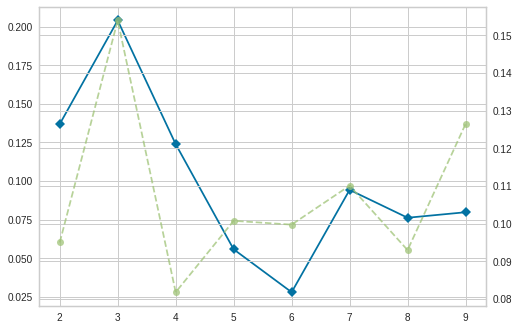

In [11]:
full_Kelbow_pipe.fit(df_part[1000:3000]) # should choose random rows!

In [12]:
y_km_full = full_pipe.fit_predict(df_part)

In [13]:
full_features_decomp = full_decomp_pipe.fit_transform(df_part)

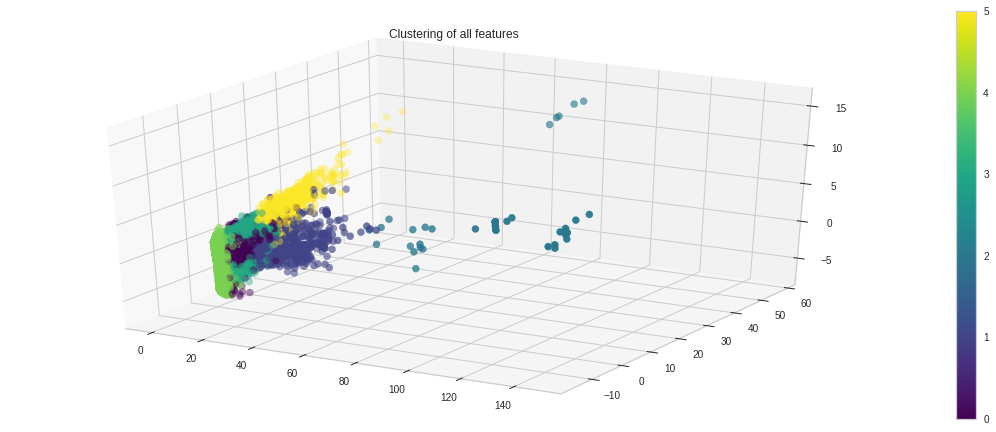

In [14]:
full_fig = plt.figure(figsize=(20, 7.5))
full_ax = full_fig.add_subplot(111, projection='3d')

full_scatter = full_ax.scatter(full_features_decomp[:, 0], full_features_decomp[:, 1], full_features_decomp[:, 2], c=y_km_full, s=50, cmap='viridis')
plt.title('Clustering of all features')
plt.colorbar(full_scatter, ticks=np.arange(6))
plt.show()

In [15]:
full_fig.savefig('../Figures/CLST_all_features.png', bbox_inches='tight')

# Clustering: parties not in clean text

In [16]:
clean_mapper = DataFrameMapper([('tags', tags_pipe),
                               ('parties', parties_pipe),
                               ('mentions', tags_pipe),
                               ('no_parties', text_pipe)])

clean_pipe = Pipeline([('mapper', clean_mapper),
                       ('clust', MiniBatchKMeans(n_clusters=3, 
                                                 batch_size=5000,
                                                 n_init = 1000, 
                                                 init='k-means++', 
                                                 max_iter=100))])

clean_kelbow_pipe = Pipeline([('mapper', full_mapper),
                        ('viz', KElbowVisualizer(MiniBatchKMeans(), 
                                                 metric='silhouette', 
                                                 k=[2, 19]))])

clean_decomp_pipe = Pipeline([('mapper', clean_mapper),
                              ('decomp', TruncatedSVD(n_components=3))])

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('tags', Pipeline(memory=None,
     steps=[('fhasher', FeatureHasher(alternate_sign=True, dtype=<class 'numpy.float64'>,
       input_type='string', n_features=1000, non_negative=False))])), ('parties', Pipeline(memory=...ots.AxesSubplot object at 0x7f9364a81b38>,
         k=None, metric=None, model=None, timings=True))])

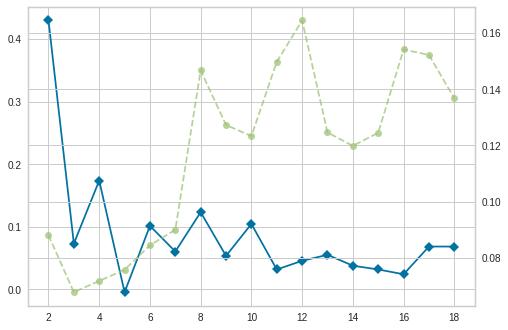

In [17]:
clean_kelbow_pipe.fit(df_part[1000:3000])

In [18]:
y_km_clean = clean_pipe.fit_predict(df_part)

In [19]:
clean_features_decomp = clean_decomp_pipe.fit_transform(df_part)

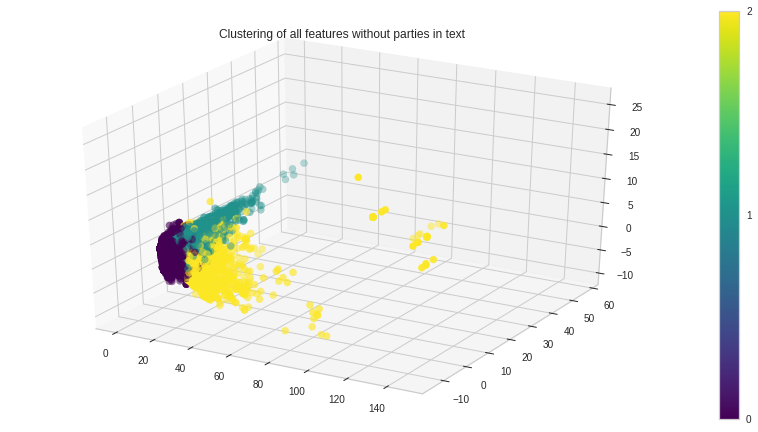

In [20]:
clean_fig = plt.figure(figsize=(15, 7.5))
clean_ax = clean_fig.add_subplot(111, projection='3d')

clean_scatter = clean_ax.scatter(clean_features_decomp[:, 0], clean_features_decomp[:, 1], clean_features_decomp[:, 2], c=y_km_clean, s=50, cmap='viridis')
plt.title('Clustering of all features without parties in text')
plt.colorbar(clean_scatter, ticks=np.arange(3))
plt.show()

In [21]:
clean_fig.savefig('../Figures/CLST_allf_noparties.png', bbox_inches='tight')

### Clustering: full, uncleaned text


In [22]:
svd = TruncatedSVD(n_components=3)

In [26]:
qd_X = text_pipe.fit_transform(all_data.loc[:, 'full_text'].tolist())

In [27]:
print(qd_X.shape)

(46267, 80)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f93655bf198>,
         k=None, metric=None, model=None, timings=True)

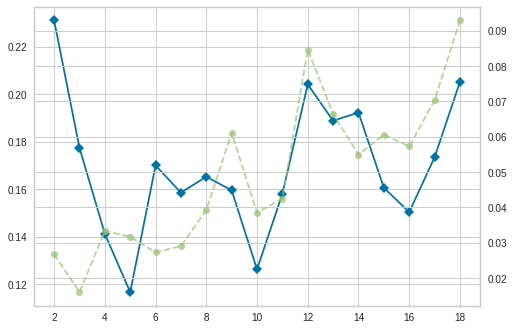

In [28]:
"""
Use the elbow visualizer to find the optimal number of clusters for KMeans
Use MiniBatchKMeans to circumvent memory errors
"""

visualizer = KElbowVisualizer(MiniBatchKMeans(), metric='silhouette', k=[2, 19])
visualizer.fit(qd_X[1000:3000])

In [29]:
""" 
Define MiniBatchKMeans with the optimal number of clusters derived from the elbow visualizer
Use MiniBatchKMeans to circumvent memory errors
"""

qd_kmeans = MiniBatchKMeans(n_clusters=4, 
                            batch_size = 5000,
                            n_init = 1000, 
                            init='k-means++',
                            max_iter=50)

In [30]:
qd_y = qd_kmeans.fit_predict(qd_X)

In [31]:
qd_X_decomp = svd.fit_transform(qd_X)

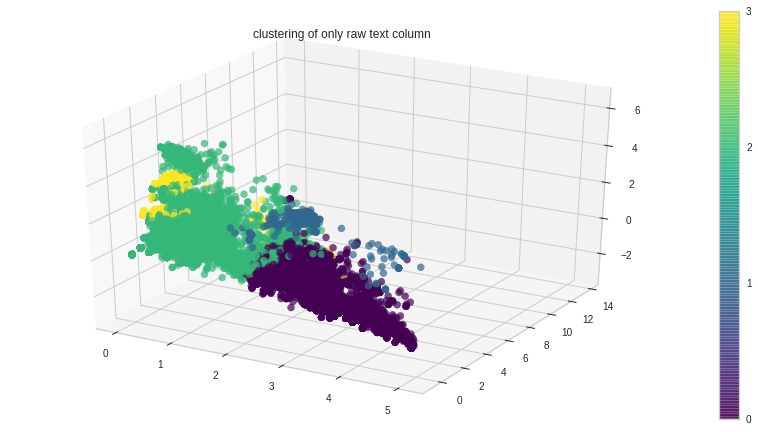

In [32]:
""" Plot features, cluster and cluster centers"""
xs = qd_X_decomp[:, 0]
ys = qd_X_decomp[:, 1]
zs = qd_X_decomp[:, 2]

qd_fig = plt.figure(figsize=(15, 7.5))
qd_ax = qd_fig.add_subplot(111, projection='3d')
qd_scatter = qd_ax.scatter(xs=xs, ys=ys, zs=zs, c=qd_y, s=50, cmap='viridis', alpha=0.7)
plt.title('clustering of only raw text column')
plt.colorbar(qd_scatter, ticks=np.arange(5))
plt.show()

In [33]:
qd_fig.savefig('../Figures/CLST_qd_rawtext.png', bbox_inches='tight')

### Clustering: only clean text, with parties

In [34]:
clean_text = df_part.loc[:, 'clean_text']

In [36]:
X_ct = text_pipe.fit_transform(clean_text)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f93579d55f8>,
         k=None, metric=None, model=None, timings=True)

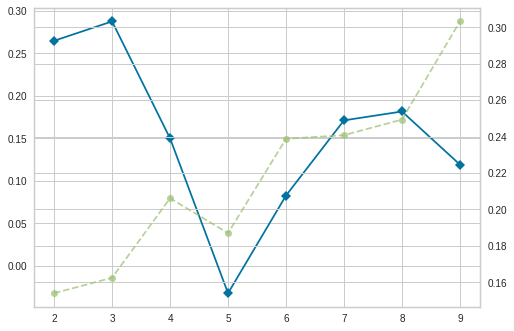

In [58]:
visualizer_ct = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 10])
visualizer_ct.fit(X_ct[1000:3000])

In [59]:
ct_kmeans = MiniBatchKMeans(n_clusters=5, 
                            batch_size = 5000,
                            n_init = 1000, 
                            init='k-means++',
                            max_iter=200)

In [60]:
y_km_ct = ct_kmeans.fit_predict(X_ct)

In [61]:
X_ct_decomp = svd.fit_transform(X_ct)

In [62]:
ct_centers = ct_kmeans.cluster_centers_

In [63]:
ct_centers_decomp = svd.fit_transform(ct_centers)

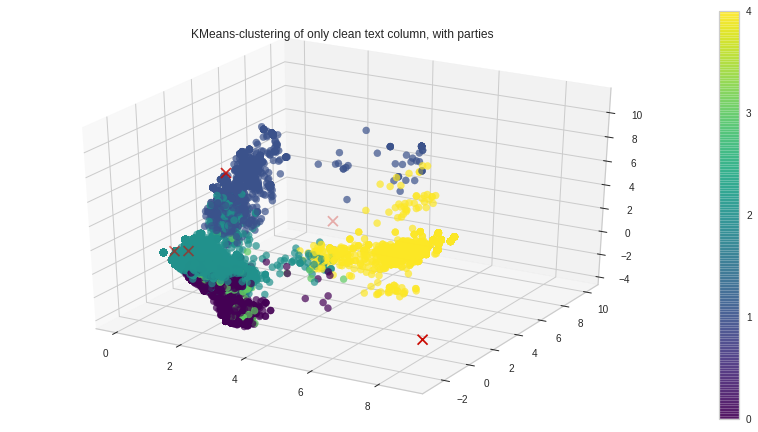

In [67]:
""" Plot features, cluster and cluster centers"""
xs = X_ct_decomp[:, 0]
ys = X_ct_decomp[:, 1]
zs = X_ct_decomp[:, 2]

fig_ct = plt.figure(figsize=(15, 7.5))
ax_ct = fig_ct.add_subplot(111, projection='3d')
scatter = ax_ct.scatter(xs=xs, ys=ys, zs=zs, c=y_km_ct, s=50, cmap='viridis', alpha=0.7)
scatter2 = ax_ct.scatter(xs=ct_centers_decomp[:,0], ys=ct_centers_decomp[:,1], zs=ct_centers_decomp[:,2], s=100, marker='x', c='r')
plt.title('KMeans-clustering of only clean text column, with parties')
plt.colorbar(scatter, ticks=np.arange(5))
plt.show()

In [68]:
fig_ct.savefig('../Figures/CLST_text_ct.png', bbox_inches='tight')

### Clustering: only clean text, with parties

In [46]:
np_text = df_part.loc[:, 'no_parties']

In [47]:
X_np = text_pipe.fit_transform(np_text)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f935db16a20>,
         k=None, metric=None, model=None, timings=True)

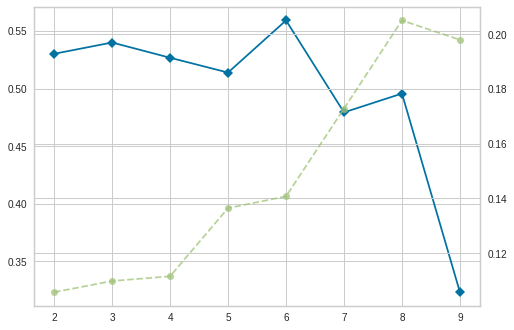

In [69]:
visualizer_np = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 10])
visualizer_np.fit(X_np[1000:3000])

In [70]:
np_kmeans = MiniBatchKMeans(n_clusters=3, 
                            batch_size = 5000,
                            n_init = 1000, 
                            init='k-means++',
                            max_iter=500)

In [71]:
y_km_np = np_kmeans.fit_predict(X_np)

In [72]:
X_np_decomp = svd.fit_transform(X_np)

In [73]:
np_centers = np_kmeans.cluster_centers_

In [74]:
np_centers_decomp = svd.fit_transform(np_centers)

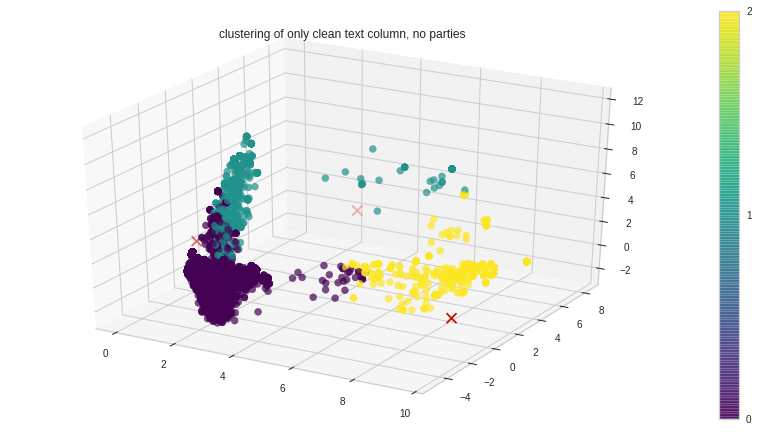

In [75]:
""" Plot features, cluster and cluster centers"""
xs = X_np_decomp[:, 0]
ys = X_np_decomp[:, 1]
zs = X_np_decomp[:, 2]

fig_np = plt.figure(figsize=(15, 7.5))
ax_np = fig_np.add_subplot(111, projection='3d')
scatter = ax_np.scatter(xs=xs, ys=ys, zs=zs, c=y_km_np, s=50, cmap='viridis', alpha=0.7)
scatter2 = ax_np.scatter(xs=np_centers_decomp[:,0], ys=np_centers_decomp[:,1], zs=np_centers_decomp[:,2], s=100, marker='x', c='r')
plt.title('clustering of only clean text column, no parties')
plt.colorbar(scatter, ticks=np.arange(3))
plt.show()

In [76]:
fig_np.savefig('../Figures/CLST_text_np.png', bbox_inches='tight')

# Clustering evaluation
1. Focus on only text clustering
2. What difference do parties in the text make
3. 

In [77]:
all_data['np_labels'] = np_kmeans.labels_

In [78]:
all_data['ct_labels'] = ct_kmeans.labels_